# Supervised learning

Classification of points on 2D plane using a 2-qubit quantum circuit. Here we encode a 2-dimensional vector $(\theta_1, \theta_2)$ into a 2-qubit state, and use a parametrized circuit to perform further classification.

The circuit is the following:

<img src="qnn_circuit3.png" width="50%">

The first part is an encoding circuit that serves as a feature map which maps a data point $(\theta_1,\theta_2)$ into a 2-qubit state. The second part is a classifier which produces the output as the probability $p$ of measuring $|0\rangle$ in the top qubit.

References:

The set up of quantum neural network: https://arxiv.org/abs/1802.06002

The encoding idea: https://arxiv.org/abs/1804.00633

The ansatz design: https://arxiv.org/abs/1804.11326

In [1]:
# Basic parameters
import numpy as np
import matplotlib.pyplot as plt

from pyquil.api import get_qc, pyquil_protect
from pyquil.quil import Program
from pyquil.gates import *

from math import *

In [2]:
# Function running the quantum circuit
def qnn(input_vec, params, qubits_chosen):
    
    """
    Args:
        input_vec - the 2D input vector to be classified
        params - the parameters for the classification circuit
        qubits_chosen - indices of the chosen qubits
    
    Returns:
        A program object describing the circuit
    """
    
    t0 = input_vec[0]
    t1 = input_vec[1]
    
    p0 = params[0]
    p1 = params[1]
    
    q0 = qubits_chosen[0]
    q1 = qubits_chosen[1]
    
    qubits = [q0, q1]
    
    program = Program(
            RX(t0, q0),
            RX(t1, q1), # Encoding circuit
            CZ(q0, q1), 
            RX(p0, q0),
            RX(p1, q1), # Unitary layer
#             MEASURE(q0, 0),
#             MEASURE(q1, 1)
        )
    
    memory_size = len(qubits)
    ro = program.declare('ro', memory_type='BIT', memory_size=memory_size)
    for i in range(memory_size):
        program += MEASURE(qubits[i], ro[i])
    
    return program

Now we run one instance of the circuit on the QPU with randomly assigned parameters.

In [3]:
# Test run the circuit

N_RUNS = 10000

input_vec = [0.1, -0.2]
params = [np.random.uniform(-pi/2, pi/2) for x in range(0,4)]
qubits_chosen = [0, 1]

qnn_prog = qnn(input_vec, params, qubits_chosen)

In [4]:
print(qnn_prog)

RX(0.1) 0
RX(-0.2) 1
CZ 0 1
RX(-1.0987201677866214) 0
RX(1.1043433073578233) 1
DECLARE ro BIT[2]
MEASURE 0 ro[0]
MEASURE 1 ro[1]



In [5]:
# Set up connection
forest_cxn = get_qc('9q-generic-qvm')

In [6]:
# Compile circuit
qnn_wrapped_circuit = qnn_prog.wrap_in_numshots_loop(N_RUNS)
qnn_native_circuit = forest_cxn.compiler.quil_to_native_quil(qnn_wrapped_circuit)
qnn_circuit_executable = forest_cxn.compiler.native_quil_to_executable(qnn_native_circuit)

# Execute circuit
result = forest_cxn.run(qnn_circuit_executable)

num_q0_1 = 0
for x in result:
    if x[0] == 1:
        num_q0_1 = num_q0_1 + 1
qvm_prob = float(num_q0_1) / float(N_RUNS)
print("\nProbability: {}".format(qvm_prob))


Probability: 0.231


## Linearly inseparable data

We generate synthetic data points in 2D that are linearly inseparable

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


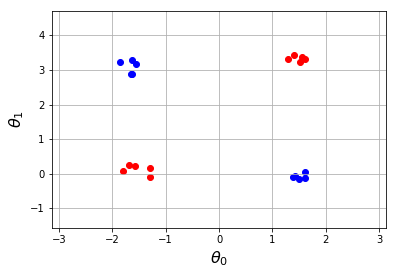

In [7]:
# Generate linearly separable data
Ndata = 5 # Number of data points per point group
delta = pi/10 # range of perturbation
#group0 = [[-pi/2+np.random.uniform(-delta,delta), np.random.uniform(-delta, delta)] for x in range(0, Ndata)]\
#        + [[pi/2+np.random.uniform(-delta,delta), pi+np.random.uniform(-delta, delta)] for x in range(0, Ndata)]
#group1 = [[-pi/2+np.random.uniform(-delta,delta), pi+np.random.uniform(-delta, delta)] for x in range(0, Ndata)]\
#        + [[pi/2+np.random.uniform(-delta,delta), np.random.uniform(-delta, delta)] for x in range(0, Ndata)]
group0 = [[-1.8014030885341425, 0.07049090664351776],
          [-1.301866318505309, -0.09006021655705085],
          [-1.2995311803877012, 0.17179375194954777],
          [-1.6844614700570668, 0.26300082528677904],
          [-1.581826822227654, 0.2210431121474794],
          [1.526782533409962, 3.227296155921321],
          [1.6081456320334693, 3.3248683153683958],
          [1.4118513018150587, 3.436121923699187],
          [1.5620769416428386, 3.384965966733096],
          [1.3020823312222616, 3.3163245524916936]]
group1 = [[-1.6269012492495667, 2.8732368479226293],
          [-1.5530830764355592, 3.1738353675554416],
          [-1.8513100742724584, 3.2237767325843545],
          [-1.6272074871316728, 3.28878799481208],
          [-1.6612433455383213, 2.879163347517711],
          [1.3798060401258543, -0.09979143378370409],
          [1.6151621300228456, 0.04571164290639079],
          [1.426884637605485, -0.06169454299108834],
          [1.5019812981463012, -0.16369059365023533],
          [1.6204586467622049, -0.10966267374801358]]

# Plot the data points
plt.xlim(-pi,pi)
plt.ylim(-pi/2,pi+pi/2)
plt.scatter([x[0] for x in group0], [x[1] for x in group0], c="r")
plt.scatter([x[0] for x in group1], [x[1] for x in group1], c="b")
plt.xlabel(r'$\theta_0$',fontsize=16)
plt.ylabel(r'$\theta_1$',fontsize=16)
plt.grid('on')
# plt.savefig('xor.pdf')
plt.show()

In [16]:
# Function for one evaluation of a data point on a QPU
qubits_chosen = [0, 1]

def evaluate_q0(input_vec, params, qubits_chosen):
    """
    Objective function is the probability of q0 being |1>
    """
    
    qnn_prog = qnn(input_vec, params, qubits_chosen)

    # Open connection to the QVM
    forest_cxn = get_qc('9q-generic-qvm')
    
    # Compile circuit
    qnn_wrapped_circuit = qnn_prog.wrap_in_numshots_loop(N_RUNS)
    qnn_native_circuit = forest_cxn.compiler.quil_to_native_quil(qnn_wrapped_circuit)
    qnn_circuit_executable = forest_cxn.compiler.native_quil_to_executable(qnn_native_circuit)

    # Execute circuit
    result = forest_cxn.run(qnn_circuit_executable)

    num_q0_1 = 0
    for x in result:
        if x[0] == 1:
            num_q0_1 = num_q0_1 + 1
    qvm_prob = float(num_q0_1) / float(N_RUNS)
    print("\nProbability: {}".format(qvm_prob))
    
    return qvm_prob

In [17]:
# Training objective
def targetfunc_q0(params):
    
    prob_group0 = []
    #print('Group 0')
    for input_vec in group0:
        qpu_prob = evaluate_q0(input_vec, params, qubits_chosen)
        prob_group0 = prob_group0 + [qpu_prob]
    
    prob_group1 = []
    #print('Group 1')
    for input_vec in group1:
        qpu_prob = evaluate_q0(input_vec, params, qubits_chosen)
        prob_group1 = prob_group1 + [qpu_prob]
    
    output = -(np.mean([log(x) for x in prob_group0]) - np.mean([log(x) for x in prob_group1]))
    #print('Output={}'.format(output))
    print("Current output: {}".format(output))
    return output

In [18]:
from scipy.optimize import minimize
from matplotlib import cm

init_list_params = [3.0672044712460114, 3.3311348339721203]
# Sanity check: 
# http://www.wolframalpha.com/input/?i=plot+cos(x%2F2)%5E2*sin(y%2F2)%5E2%2Bsin(x%2F2)%5E2*cos(y%2F2)%5E2%2B1%2F2*sin(y)*sin(x)*cos(z)+for+y%3D3.0
init_simplex = [init_list_params]
for x in range(0,2):
    perturbed_params = [y+np.random.uniform(-pi, pi) for y in init_list_params]
    init_simplex = init_simplex + [perturbed_params]

def plot_decision_boundary(params,filename):
    
    Nmesh = 5
    range0 = np.linspace(-pi, pi, Nmesh)
    range1 = np.linspace(-pi/2, pi+pi/2, Nmesh)

    range_inputs = []
    func_vals = []

    for y in range1:
        for x in range0:
            range_inputs = range_inputs + [[x,y]]
            func_vals = func_vals + [evaluate_q0([x,y], params, qubits_chosen)]

    # Plot the decision boundaries
    x = list(np.kron(range1, [1 for i in range(0,Nmesh)]))
    #y = list(np.kron([1 for i in range(0,Nmesh)], range0))
    X, Y = np.meshgrid(range0, range1)

    # colors = func_vals
    Z = np.reshape(func_vals, [Nmesh, Nmesh])

    levels = np.arange(-3.5, 3.5, 0.1)
    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
    cmap = cm.PRGn

    plt.contourf(X, Y, Z, levels, cmap=cm.get_cmap(cmap, len(levels) - 1), norm=norm)
    plt.scatter([x[0] for x in group0], [x[1] for x in group0], c="r")
    plt.scatter([x[0] for x in group1], [x[1] for x in group1], c="b")

    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    plt.xlabel(r'$\theta_0$',fontsize=16)
    plt.ylabel(r'$\theta_1$',fontsize=16)
    #plt.title(title)

    plt.savefig(filename)
    plt.show()


Probability: 0.0005

Probability: 0.5005

Probability: 0.9988

Probability: 0.5024

Probability: 0.0012

Probability: 0.0012

Probability: 0.4708

Probability: 0.9986

Probability: 0.533

Probability: 0.0012

Probability: 0.0012

Probability: 0.509

Probability: 0.998

Probability: 0.5088

Probability: 0.0009

Probability: 0.0009

Probability: 0.5314

Probability: 0.9989

Probability: 0.4582

Probability: 0.0009

Probability: 0.0009

Probability: 0.5031

Probability: 0.9993

Probability: 0.501

Probability: 0.0014


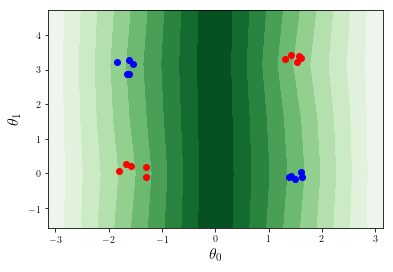

In [19]:
plot_decision_boundary(init_list_params, 'init_boundary_qvm_qcs.pdf')

In [12]:
# Callback function for displaying progress
Nfeval = 1
min_loss_history = []
    
def callback_func(input_params):
    global Nfeval
    global min_loss_history
    loss = targetfunc_q0(input_params)
    list_display = [Nfeval]
    list_display.extend(input_params)
    list_display.append(loss)
    Nfeval += 1
    min_loss_history.append(loss)
    
def targetfunc(x):
    try:
        return targetfunc_q0(x)
    except:
        return targetfunc_q0(x)
    
# Train the classifier
res = minimize(targetfunc, init_list_params, args=(),
               method='Nelder-Mead', tol=1e-2, 
               callback=callback_func, options={'disp': False,
                                                'initial_simplex': init_simplex,
                                                'maxiter': 20,
                                                'xatol': 0.01,
                                                'return_all': False,
                                                'fatol': 0.01})

Current output: 0.06899301408013736
Current output: -2.0518596971669005
Current output: -1.6067004970041678
Current output: 4.20920973669139
Current output: -2.985281461066774
Current output: -3.025106874342976
Current output: -2.3737824710569453
Current output: -2.990886979516905
Current output: 0.23568897762604712
Current output: -5.059593379271113
Current output: -5.004704804486291
Current output: -4.248907553606002
Current output: -4.993360066621519
Current output: -1.810833152732939
Current output: -4.472923344373136
Current output: -4.921282239043035
Current output: -3.74541415507524
Current output: -4.77505330602809
Current output: -5.014320181309342
Current output: -3.595036759410094
Current output: -5.191600858055053
Current output: -5.177042189021276
Current output: -4.986391533780622
Current output: -5.081198561626774
Current output: -5.169932578289066
Current output: -4.656081907368045
Current output: -5.127429853935968
Current output: -5.100462479928198
Current output: -5.

In [13]:
print(res)

 final_simplex: (array([[4.69191443, 2.17921824],
       [4.69291865, 2.16642877],
       [4.6903535 , 2.18146648]]), array([-5.32372819, -5.30200521, -5.25029924]))
           fun: -5.3237281903657205
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 44
           nit: 20
        status: 2
       success: False
             x: array([4.69191443, 2.17921824])


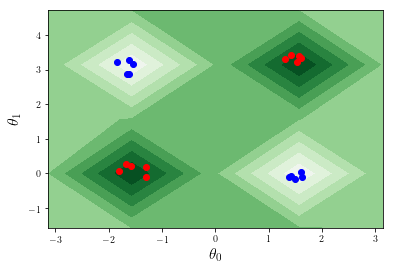

In [14]:
# Print decision boundary performing a grid evaluation of the optimized circuit
params = res.x
plot_decision_boundary(params, 'final_boundary_qvm_qcs.pdf')

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


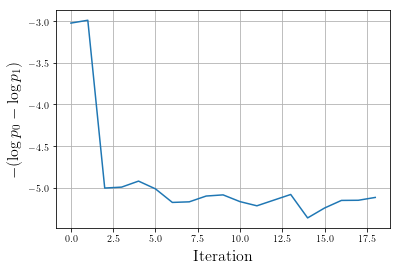

In [15]:
# Plot training curve
plt.plot(range(0, len(min_loss_history)), min_loss_history)
plt.grid('on')

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.xlabel(r'Iteration',fontsize=16)
plt.ylabel(r'$-(\log p_0-\log p_1)$',fontsize=16)
plt.savefig('training_curve_qcs.pdf')

plt.show()